In [1]:
!pip install transformers
!pip install pytorch-crf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import torch
import transformers
from transformers import BertTokenizer, BertModel
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tqdm import tqdm, trange

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
class Config(object):
    dev = False

    train_path = "drive/MyDrive/HLE-project/data/train.csv"
    validation_path = "drive/MyDrive/HLE-project/data/validation.csv"
    test_path = "drive/MyDrive/HLE-project/data/test.csv"

    # model / optimizer parameters
    bert_model: str = 'allenai/scibert_scivocab_cased' #all considered models: #allenai/scibert_scivocab_cased #bert-base-cased 
    use_crf = True
    full_finetuning: bool = True # toggle if all hyperparameters are fine-tuned. if False only parameters of classifier are fine-tuned
    epochs: int = 5
    sequence_length: int = 512 # sequence length of the bert model
    batch_size: int = 16 # batch size used during training / testing
    hidden_dropout_prob: float = 0.1 # hidden dropout probability, BERT default is 0.1
    lr: float = 5e-5 # lerning rate, best feeling: 4.5e-5 or 5e-5, best values were between 1e-5 and 6e-5
    eps: float = 1e-8 # Adams epsilon parameter for numerical stability
    warmup_steps: int = 0 # warm up steps (not investigated any numbers but 0)
    max_grad_norm: float = 1.0 # clip the norm of the gradient

    update_step = 100
    
config = Config()

In [5]:
# importing module
import sys
 
# appending a path
sys.path.append('drive/MyDrive/HLE-project')

from get_dataloader import get_dataloader
train_dataloader, tag_values, tag2idx = get_dataloader(config.train_path, 
                                                      data_kind="train", 
                                                      tag_values=None,
                                                      bert_model=config.bert_model, 
                                                      dev=config.dev, 
                                                      sequence_length=config.sequence_length, 
                                                      batch_size=config.batch_size)

validation_dataloader, _, _ = get_dataloader(config.validation_path, 
                                                      data_kind="validation", 
                                                      tag_values=tag_values,
                                                      bert_model=config.bert_model, 
                                                      dev=config.dev, 
                                                      sequence_length=config.sequence_length, 
                                                      batch_size=config.batch_size)

{'O': 345172, 'B-Definition': 6062, 'I-Definition': 87142, 'B-Term': 6611, 'I-Term': 9551, 'B-Alias-Term': 726, 'I-Alias-Term': 860, 'B-Secondary-Definition': 479, 'I-Secondary-Definition': 8227, 'B-Ordered-Term': 5, 'I-Ordered-Term': 13, 'B-Ordered-Definition': 5, 'I-Ordered-Definition': 51, 'B-Referential-Definition': 308, 'I-Referential-Definition': 661, 'B-Qualifier': 162, 'I-Qualifier': 1045, 'B-Referential-Term': 140, 'B-Definition-frag': 85, 'I-Definition-frag': 955, 'I-Referential-Term': 116, 'B-Term-frag': 8, 'B-Alias-Term-frag': 3, 'I-Term-frag': 3}

Total sentences:  24106
Total labels:  468390

Following tags and their corresponding IDs will be used:  {'B-Alias-Term': 0, 'B-Alias-Term-frag': 1, 'B-Definition': 2, 'B-Definition-frag': 3, 'B-Ordered-Definition': 4, 'B-Ordered-Term': 5, 'B-Qualifier': 6, 'B-Referential-Definition': 7, 'B-Referential-Term': 8, 'B-Secondary-Definition': 9, 'B-Term': 10, 'B-Term-frag': 11, 'I-Alias-Term': 12, 'I-Definition': 13, 'I-Definition-fra

Downloading:   0%|          | 0.00/222k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

{'O': 16522, 'B-Term': 323, 'I-Term': 433, 'B-Definition': 296, 'I-Definition': 4324, 'B-Secondary-Definition': 17, 'I-Secondary-Definition': 350, 'B-Definition-frag': 1, 'I-Definition-frag': 2, 'B-Alias-Term': 26, 'I-Alias-Term': 30, 'B-Qualifier': 5, 'I-Qualifier': 29, 'B-Referential-Term': 4, 'B-Referential-Definition': 8, 'I-Referential-Definition': 9, 'I-Referential-Term': 1, 'B-Ordered-Term': 1, 'I-Ordered-Term': 8, 'B-Ordered-Definition': 1, 'I-Ordered-Definition': 22}

Total sentences:  1179
Total labels:  22412

Following tags and their corresponding IDs will be used:  {'B-Alias-Term': 0, 'B-Alias-Term-frag': 1, 'B-Definition': 2, 'B-Definition-frag': 3, 'B-Ordered-Definition': 4, 'B-Ordered-Term': 5, 'B-Qualifier': 6, 'B-Referential-Definition': 7, 'B-Referential-Term': 8, 'B-Secondary-Definition': 9, 'B-Term': 10, 'B-Term-frag': 11, 'I-Alias-Term': 12, 'I-Definition': 13, 'I-Definition-frag': 14, 'I-Ordered-Definition': 15, 'I-Ordered-Term': 16, 'I-Qualifier': 17, 'I-Referen

In [6]:
def select_cuda():
    """for acceleration of the training cuda is used (gpu support)
    
    Returns:
        TYPE: Description
    """
    # if cuda is available, use gpu instead of the cpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, "will be used", "\n")

    #get amount of gpus
    n_gpu = torch.cuda.device_count()
    print("There is (are)", n_gpu, "GPU(s) available", "\n")

    # get the GPU name
    # TODO do i need to return this?
    gpu_name = torch.cuda.get_device_name(0)
    if n_gpu != 0:
        print("The GPU: '", gpu_name, "' will be used", "\n")

    return device, n_gpu

# select cuda for gpu support later in the training phase (much faster)
device, n_gpu = select_cuda()

cuda will be used 

There is (are) 1 GPU(s) available 

The GPU: ' Tesla T4 ' will be used 



In [7]:
from transformers import BertPreTrainedModel, BertModel, BertForTokenClassification
from torchcrf import CRF 

class Bert_CRF(BertPreTrainedModel):

    """a class summarizing the model architecture when crf is used on top of bert.
    
    Attributes:
        bert (TYPE): the pretrained bert model to be used
        classifier (TYPE): the classifier to be used on top of the pretrained bert model
        crf (TYPE): the conditional random field to be used for the classifiers outputs
        dropout (TYPE): dropout with its probability
        num_labels (TYPE): number of labels to be used 
    """

    def __init__(self, config):
        super(Bert_CRF, self).__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob) # 0.1 is default by BERT
        self.classifier = torch.nn.Linear(config.hidden_size, self.num_labels)
        self.init_weights()
        self.crf = CRF(self.num_labels, batch_first=True)    
    
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):  
        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        emission = self.classifier(sequence_output)    
        attention_mask = attention_mask.type(torch.uint8) # change to needed tensor
        if labels is not None:
            labels = labels.type(torch.long)      
            loss = -self.crf(emission, labels, mask=attention_mask, reduction='mean')
            return loss
        else:
            prediction = self.crf.decode(emission, mask=attention_mask)
            return prediction

In [8]:
def initialize_model(tag2idx):
    """here the two specified models of this repository are initialized:
    either BERT + BertForTokenClassification (linear layer) or BERT + CRF
    
    Args:
        tag2idx (TYPE): Description
    
    Returns:
        TYPE: Description
    """
    if config.use_crf:
        model = Bert_CRF.from_pretrained(
            config.bert_model,  # pretrained model, other option: 'bert-base-cased' etc.
            num_labels=len(tag2idx), # amount of labels passed (prob. for BertConfig)
            output_attentions = False, # Whether or not to return the attentions tensors of all attention layers. 
            output_hidden_states = False # Whether or not to return the hidden states of all layers.
        )
    else:
        # The transformer package provides a BertForTokenClassification class for token-level predictions. 
        # BertForTokenClassification is a fine-tuning model that wraps BertModel and adds token-level classifier 
        # on top of the BertModel. The token-level classifier is a linear layer that takes as input the last hidden state 
        # of the sequence.
        model = BertForTokenClassification.from_pretrained(
           config.bert_model,  # pretrained model, other option: 'bert-base-cased' etc.
           num_labels=len(tag2idx), # amount of labels passed (prob. for BertConfig)
           output_attentions = False, # Whether or not to return the attentions tensors of all attention layers. 
           output_hidden_states = False # Whether or not to return the hidden states of all layers.
        )

    #Pass the model parameters to the GPU (very important for fast progress)
    model.cuda();

    return model

# empty the cuda (gpu) cache
torch.cuda.empty_cache()

# initialize the BERT model
model = initialize_model(tag2idx)

Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_cased were not used when initializing Bert_CRF: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing Bert_CRF from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Bert_CRF from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Bert_CRF were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are

In [9]:
from transformers import AdamW

def initialize_optimizer(model):
    """Having the initialized model as input, this method initializes an optimizer
    
    Args:
        model (TYPE): Description
    
    Returns:
        TYPE: Description
    """
    # Before we can start the fine-tuning process, we have to setup the optimizer and add the parameters it should update. 
    # A common choice is the AdamW optimizer. We also add some weight_decay as regularization to the main weight matrices. 
    # If you have limited resources, you can also try to just train the linear classifier on top of BERT and keep all other weights fixed. This will still give you a good performance.
    if config.full_finetuning:
        # Returns an iterator over module parameters, yielding both the name of the parameter as well as the parameter itself.
        param_optimizer = list(model.named_parameters()) # all parameters to be optimized
        
        # there are different types of model parameters in model.named_parameters(). for the 3 values bias, gamma, beta
        # there should be no decay in the learning rate of these paramters. For all other parameters the decay is 0.01
        no_decay = ['bias', 'gamma', 'beta']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.01}, # was 0.01
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.0}
        ]
    else:
        param_optimizer = list(model.classifier.named_parameters()) # only optimize parameters of classifier (linear layer)
        optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

    # TODO change optimizer
    # pass the parameters to the AdamW optimizer, define learning rate, define epsilon ?
    optimizer = AdamW(
        optimizer_grouped_parameters, #passed parameters
        lr=config.lr, # learning rate, (automatic parameter search maybe) go down up with values (always used 3e-5)
        eps=config.eps # Is a very small number to prevent any division by zero in the implementation (e.g. 10E-8)
    )

    return optimizer

# initialize the AdamW optimizer
optimizer = initialize_optimizer(model)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
from transformers import get_linear_schedule_with_warmup

# Total number of training steps is number of batches * number of epochs. (for scheduler)
total_steps = len(train_dataloader) * config.epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=config.warmup_steps,
    num_training_steps=total_steps
)

In [12]:
import time
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def save_checkpoint(epoch, model, optimizer, scheduler, tag_values, loss_values, validation_loss_values, precision_scores, recall_scores, f1_scores, save_config=False): #TODO update doc
    """method for saving a checkpoint of model training and if wanted the config values, too
    
    Args:
        epoch (TYPE): current epoch
        model (TYPE): current model (parameters)
        optimizer (TYPE): current optimizer (parameters)
        scheduler (TYPE): current scheduler (parameters)
        tag_values (TYPE): used tag_values
        loss_values (TYPE): so far all collected loss values
        validation_loss_values (TYPE): so far all collected validation loss values
    """
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'tag_values': tag_values, # for correct order of labels and to recognize what was trained
        'loss_values': loss_values,
        'validation_loss_values': validation_loss_values,
        'precision_scores': precision_scores,
        'recall_scores': recall_scores,
        'f1_scores': f1_scores,
        'config': config
    }
    torch.save(state, 'drive/MyDrive/HLE-project/model_checkpoints/checkpoint_scibert_{ep}.pt'.format(ep = epoch)) 

def calculate_relevant_metrics(y_true: list, y_pred: list, tag2idx: dict):
    """The classification metrics precision, recall and f1-score are calculated and returned.
    If wanted a classification report can be returned. It contains the above mentioned metrics
    for all labels.
    
    Args:
        y_true (list): Description
        y_pred (list): Description
        tag_values (list): Description
        report_wanted (bool, optional): Description
    
    Returns:
        TYPE: Description
    """
    #pred_tags = [tag_values[p_i] for p, l in zip(y_pred, y_true)
    #                             for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    #true_tags = [tag_values[l_i] for l in y_true
    #                              for l_i in l if tag_values[l_i] != "PAD"]
    
    y_true = [item for sublist in y_true for item in sublist]
    y_pred = [item for sublist in y_pred for item in sublist]
    
    unwanted_labels_for_evaluation = [tag2idx['O'], tag2idx['PAD']]
    
    for index, i in enumerate(y_true):
        if i==unwanted_labels_for_evaluation[0] or i==unwanted_labels_for_evaluation[1] :
            del[y_true[index]]
            del[y_pred[index]]
    
    current_precision_score = precision_score(y_true, y_pred, average="macro")
    current_recall_score = recall_score(y_true, y_pred, average="macro")
    current_f1_score = f1_score(y_true, y_pred, average="macro")
    
    current_precision_score2 = precision_score(y_true, y_pred, average="micro")
    current_recall_score2 = recall_score(y_true, y_pred, average="micro")
    current_f1_score2 = f1_score(y_true, y_pred, average="micro")
    
    current_precision_score = [current_precision_score, current_precision_score2]
    current_recall_score = [current_recall_score, current_recall_score2]
    current_f1_score = [current_f1_score, current_f1_score2]

    result_classification_report = classification_report(y_true, y_pred, digits = 4, output_dict = True)
    return current_precision_score, current_recall_score, current_f1_score, result_classification_report

def apply_masked_select(input_tensor, mask):
    new_tensor = []
    for i in range(len(input_tensor)):
        new_tensor.append(torch.masked_select(input_tensor[i], mask[i]).tolist())
    return new_tensor

def pad_and_tensor_logits(logits, tag2idx):
    new_logits = pad_sequences([[l for l in logit] for logit in logits],
                         maxlen=config.sequence_length, 
                         dtype="long", 
                         value=tag2idx["PAD"],
                         truncating="post",
                         padding="post")
    new_logits = torch.tensor(new_logits)
    new_logits = new_logits.to(device)
    return new_logits

def train(model, optimizer, scheduler, train_dataloader, valid_dataloader, tag_values, tag2idx):
    """training of the BERT model (BERT + BertForTokenClasssification or BERT + CRF)
    
    Args:
        model (Bert_CRF): Description
        optimizer (transformers.optimization.AdamW): Description
        scheduler (torch.optim.lr_scheduler.LambdaLR): Description
        train_dataloader (torch.utils.data.dataloader.DataLoader): Description
        valid_dataloader (torch.utils.data.dataloader.DataLoader): Description
        tag_values (list): Description
        tag2idx (dict): Description
    
    Returns:
        TYPE: Description
    """
    # measuring length of the training phase
    startTime = time.time()

    # saving loss for both training and validation phase
    loss_values, validation_loss_values = [], []

    # saving precision-, recall- and f1 - scores for every epoch, also for plotting
    precision_scores, recall_scores, f1_scores = [], [], [] 

    # specify epochs to train
    epochs_to_train = config.epochs

    # print total iterations
    print("Total iterations to be made: ", epochs_to_train * len(train_dataloader), "\n")
    
    # trange is for smart progress meter showing
    for e in trange(epochs_to_train, desc="Epoch"):
        # ========================================
        #               Training
        # ========================================
        # Perform one full pass over the training set.

        # Put the model into training mode.
        model.train()
        # Reset the total loss for this epoch.
        total_loss = 0
        
        # Training loop, tqdm for progress bar viewing 
        with tqdm(total=len(train_dataloader), desc = "training progress") as progress_bar: 
            for step, batch in enumerate(train_dataloader):

                # add batch to gpu
                batch = tuple(t.to(device) for t in batch)

                b_input_ids, b_input_mask, b_labels, b_filter_masks = batch
                
                optimizer.zero_grad()
                
                # forward pass
                # This will return the loss (rather than the model output)
                # because we have provided the `labels`.
                loss = model(b_input_ids, 
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels) 

                if not config.use_crf:
                    # when using BertForTokenClassification the output of the model is different:
                    # output is a TokenClassifierOutput consisting of
                    # loss, logits, hidden_states, attentions (in correctly this order)
                    # thus we need index 0 to get the loss
                    loss = loss[0]

                # Perform a backward pass to calculate the gradients.
                loss.backward() 
                
                # track train loss
                total_loss += loss.item()
                
                # Clip the norm of the gradient
                # This is to help prevent the "exploding gradients" problem.
                torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=config.max_grad_norm)

                # update parameters
                optimizer.step()
                # Update the learning rate.
                scheduler.step()
                # Always clear any previously calculated gradients before performing a backward pass.
                model.zero_grad() #maybe put forward before step
                
                # update progress
                if ((step + 1) % config.update_step == 0):
                    print("At step %d of epoch %d we have loss: %f" %(step + 1, e, loss.item()))
                    progress_bar.update(config.update_step) # for progress bar viewing 
                

        print("TRAINING OF {}. EPOCH ACCOMPLISHED !".format(e+1))
        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)
        print("Average train loss: {} \n".format(avg_train_loss))

        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)


        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        # Put the model into evaluation mode
        model.eval()
        # Reset the validation loss for this epoch.
        eval_loss, eval_accuracy = 0, 0
        predictions, true_labels = [], []
        for batch in valid_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels, b_filter_mask = batch
            if config.use_crf:
                # Telling the model not to compute or store gradients,
                # saving memory and speeding up validation
                with torch.no_grad():
                    # Forward pass, calculate logit predictions and validation loss.     
                    # This will return the logits rather than the loss because we have not provided labels.
                    # IN CRF THE LOGITS ALREADY OMIT THE CLASSIFICATION OF THE PAD VALUES
                    logits = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask = b_input_mask)
                    
                    # This will return the loss rather than the logits because we have provided labels.
                    loss = model(b_input_ids, 
                                 token_type_ids=None,
                                 attention_mask=b_input_mask,
                                 labels=b_labels) # token_type_ids=None,

                # get the evaluation loss
                eval_loss += loss.item()

                # save predictions without pad values
                masked_logits = apply_masked_select(pad_and_tensor_logits(logits, tag2idx), b_filter_mask)

                # add the b_labels (true labels) to true_labels for comparing with predictions and thus calculating accuracy and f1-score
                masked_b_labels = apply_masked_select(b_labels, b_filter_mask)
            
                predictions.extend(masked_logits) #TODO to cpu and numpy?
                true_labels.extend(masked_b_labels)
            else:
                # Telling the model not to compute or store gradients,
                # saving memory and speeding up validation
                with torch.no_grad():
                    # Forward pass, calculate logit predictions and validation loss.   
                    # This will return the TokenClassifierOutput as in training(see documentation BertForTokenClassification).
                    outputs = model(b_input_ids, 
                                 token_type_ids=None,
                                 attention_mask=b_input_mask,
                                 labels=b_labels) # token_type_ids=None,

                # Move logits and labels to CPU
                logits = outputs[1].detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                # get the evaluation loss.
                eval_loss += outputs[0].mean().item()
                # get the labels by taking the argmax of the softmax output and put it into predictions
                predicted_labels = [list(p) for p in np.argmax(logits, axis=2)]
                predictions.extend(predicted_labels) #TODO omit padding
                # add the true labels to true_labels for comparing with predictions and thus calculating accuracy and f1-score
                true_labels.extend(label_ids) #TODO omit padding
        
            assert len(predictions) == len(true_labels) and len(masked_logits) == len(masked_b_labels), "Please check if the length of predictions and that of true labels are identical."

        eval_loss = eval_loss / len(valid_dataloader)
        validation_loss_values.append(eval_loss)
        print("Validation loss: {} \n".format(eval_loss))
        
        current_precision_score, current_recall_score, current_f1_score, _ = calculate_relevant_metrics(true_labels, predictions, tag2idx)

        precision_scores.append(current_precision_score)
        recall_scores.append(current_recall_score)
        f1_scores.append(current_f1_score)

        print("Validation (Macro / Micro) Precision-Score: {}".format(current_precision_score))
        print("Validation (Macro / Micro) Recall-Score: {}".format(current_recall_score))
        print("Validation (Macro / Micro) F1-Score: {} \n".format(current_f1_score))

        print("VALIDATION OF {}. EPOCH ACCOMPLISHED ! \n".format(e+1))
        
        save_checkpoint(e, model, optimizer, scheduler, tag_values, loss_values, validation_loss_values, precision_scores, recall_scores, f1_scores)

    endTime = time.time() - startTime
    print(f'whole Training time: {endTime / 3600} hours')

    return loss_values, validation_loss_values, precision_scores, recall_scores, f1_scores

#execute training
loss_values, validation_loss_values, precision_scores, recall_scores, f1_scores = train( 
                                                                        model, 
                                                                        optimizer, 
                                                                        scheduler, 
                                                                        train_dataloader, 
                                                                        validation_dataloader, 
                                                                        tag_values,
                                                                        tag2idx)

Total iterations to be made:  345 



training progress:   0%|          | 0/69 [02:18<?, ?it/s]


TRAINING OF 1. EPOCH ACCOMPLISHED !
Average train loss: 206.08751667409703 



<ipython-input-12-64b503e2932d>:78: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  new_tensor.append(torch.masked_select(input_tensor[i], mask[i]).tolist())


Validation loss: 189.6307373046875 

Validation (Macro / Micro) Precision-Score: [0.2947015537014596, 0.8343290925704646]
Validation (Macro / Micro) Recall-Score: [0.27977029341070075, 0.8343290925704646]
Validation (Macro / Micro) F1-Score: [0.2738890839815572, 0.8343290925704646] 

VALIDATION OF 1. EPOCH ACCOMPLISHED ! 



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: 

TRAINING OF 2. EPOCH ACCOMPLISHED !
Average train loss: 147.50118288786516 



<ipython-input-12-64b503e2932d>:78: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  new_tensor.append(torch.masked_select(input_tensor[i], mask[i]).tolist())


Validation loss: 192.4393539428711 

Validation (Macro / Micro) Precision-Score: [0.3270883254400091, 0.8426231812750404]
Validation (Macro / Micro) Recall-Score: [0.3217137022095383, 0.8426231812750404]
Validation (Macro / Micro) F1-Score: [0.3099885825917013, 0.8426231812750404] 

VALIDATION OF 2. EPOCH ACCOMPLISHED ! 



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: 

TRAINING OF 3. EPOCH ACCOMPLISHED !
Average train loss: 109.87494449339052 



<ipython-input-12-64b503e2932d>:78: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  new_tensor.append(torch.masked_select(input_tensor[i], mask[i]).tolist())


Validation loss: 217.84833526611328 

Validation (Macro / Micro) Precision-Score: [0.37102810406464076, 0.8409362479791945]
Validation (Macro / Micro) Recall-Score: [0.31049272099188757, 0.8409362479791945]
Validation (Macro / Micro) F1-Score: [0.3132287044687067, 0.8409362479791945] 

VALIDATION OF 3. EPOCH ACCOMPLISHED ! 



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: 

TRAINING OF 4. EPOCH ACCOMPLISHED !
Average train loss: 85.97882953588514 



<ipython-input-12-64b503e2932d>:78: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  new_tensor.append(torch.masked_select(input_tensor[i], mask[i]).tolist())


Validation loss: 226.5358009338379 

Validation (Macro / Micro) Precision-Score: [0.3893425941845637, 0.8396710480073101]
Validation (Macro / Micro) Recall-Score: [0.32351533868833177, 0.8396710480073101]
Validation (Macro / Micro) F1-Score: [0.3301470014649593, 0.8396710480073101] 

VALIDATION OF 4. EPOCH ACCOMPLISHED ! 



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: 

TRAINING OF 5. EPOCH ACCOMPLISHED !
Average train loss: 80.2852767723194 



<ipython-input-12-64b503e2932d>:78: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  new_tensor.append(torch.masked_select(input_tensor[i], mask[i]).tolist())


Validation loss: 226.5358009338379 

Validation (Macro / Micro) Precision-Score: [0.3893425941845637, 0.8396710480073101]
Validation (Macro / Micro) Recall-Score: [0.32351533868833177, 0.8396710480073101]
Validation (Macro / Micro) F1-Score: [0.3301470014649593, 0.8396710480073101] 

VALIDATION OF 5. EPOCH ACCOMPLISHED ! 



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: 

whole Training time: 0.2074055415391922 hours


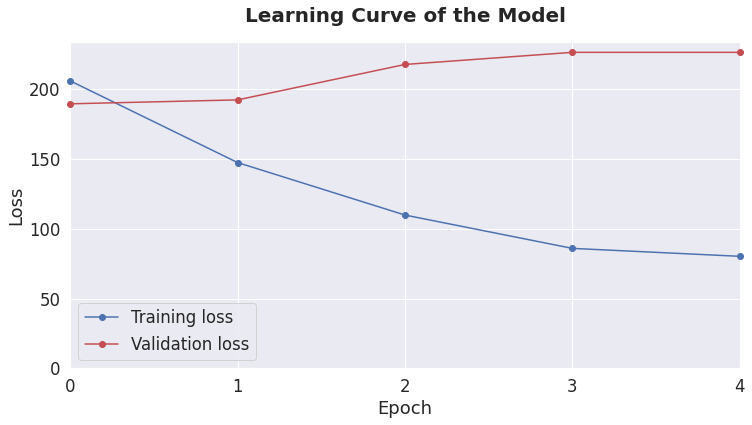

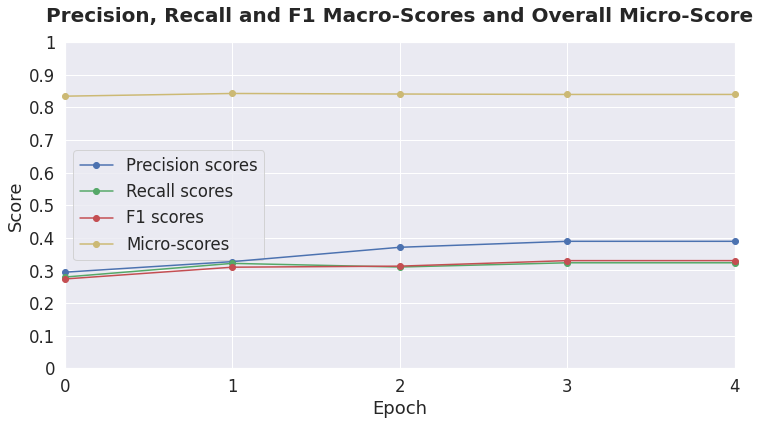

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_and_save_loss_and_scores(loss_values, validation_loss_values, precision_scores, recall_scores, f1_scores):
    """plot loss values / validation loss values and precision, recall, f1 scores in a plot each.
    Save the plots in the local directory
    
    Args:
        loss_values (list): Description
        validation_loss_values (list): Description
        precision_scores (list): Description
        recall_scores (list): Description
        f1_scores (list): Description
    """
    # ========================================
    #           general parameters
    # ========================================

    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase font size.
    sns.set(font_scale=1.5)

    # axes style
    sns.axes_style(style='ticks')

    # Increase plot size
    plt.rcParams["figure.figsize"] = (12,6) # (e.g. 12,6)

    # ========================================
    #               First plot
    # ========================================

    plt.figure(1)
    plt.xticks(np.arange(0, len(loss_values), step = 1)) #TODO change such that it start from 1

    # Plot training loss and validation loss over the epochs.
    plt.plot(loss_values, 'b-o', label="Training loss", clip_on=False, zorder=100) # the higher the zorder the more an element is "pushed" to the foreground
    plt.plot(validation_loss_values, 'r-o', label="Validation loss", clip_on=False, zorder=100)

    # Title of the first plot.
    plt.title(label='Learning Curve of the Model',
              fontsize=20,
              fontweight='bold',
              pad=20)

    # label of the x/y axis
    plt.xlabel("Epoch")
    plt.ylabel("Loss") 

    # minimum and maximum value for x and y axis
    plt.xlim([0,len(loss_values) - 1])
    plt.ylim(ymin=0)

    # show the legend
    plt.legend()

    # save the plot to the speicified path
    plt.savefig('drive/MyDrive/HLE-project/graphics/loss.svg', bbox_inches='tight') #TODO

    # ========================================
    #               Second plot
    # ========================================

    micros = [p[1] for p in f1_scores]
    precision_scores = [p[0] for p in precision_scores]
    recall_scores = [p[0] for p in recall_scores]
    f1_scores = [p[0] for p in f1_scores]
    
    plt.figure(2)
    plt.xticks(np.arange(0, len(f1_scores), step = 1)) #TODO change such that it start from 1
    plt.yticks(np.arange(0, 1.1, step = 0.1), (0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1))

    # Plot precision, recall and f1 scores over the epochs
    plt.plot(precision_scores, 'b-o', label="Precision scores", clip_on=False, zorder=100)
    plt.plot(recall_scores, 'g-o', label="Recall scores", clip_on=False, zorder=100)
    plt.plot(f1_scores, 'r-o', label="F1 scores", clip_on=False, zorder=100)
    plt.plot(micros, 'y-o', label="Micro-scores", clip_on=False, zorder=100)

    # Title of second plot.
    plt.title(label='Precision, Recall and F1 Macro-Scores and Overall Micro-Score',
              fontsize=20,
              fontweight='bold',
              pad=20) # for each epoch in the validation phase

    # label of the x/y axis
    plt.xlabel("Epoch")
    plt.ylabel("Score") 

    # minimum and maximum value for x and y axis
    plt.xlim([0,len(precision_scores) - 1])
    plt.ylim([0,1])

    # show the legend
    plt.legend()

    # save the plot to the speicified path
    plt.savefig('drive/MyDrive/HLE-project/graphics/scores.svg', bbox_inches='tight') #TODO

    # plt.show()

plot_and_save_loss_and_scores(loss_values, validation_loss_values, precision_scores, recall_scores, f1_scores)

In [14]:
from get_dataloader import get_dataloader
test_dataloader, _, _ = get_dataloader(config.test_path, 
                                                      data_kind="test", 
                                                      tag_values=tag_values,
                                                      bert_model=config.bert_model, 
                                                      dev=config.dev, 
                                                      sequence_length=config.sequence_length, 
                                                      batch_size=config.batch_size)

{'O': 16546, 'B-Term': 348, 'I-Term': 487, 'B-Definition': 312, 'I-Definition': 4184, 'B-Secondary-Definition': 18, 'I-Secondary-Definition': 303, 'B-Alias-Term': 40, 'B-Referential-Term': 5, 'B-Referential-Definition': 16, 'I-Referential-Definition': 44, 'I-Alias-Term': 32, 'B-Qualifier': 1, 'I-Qualifier': 3, 'B-Definition-frag': 3, 'I-Definition-frag': 52, 'I-Referential-Term': 9, 'B-Ordered-Term': 1, 'I-Ordered-Term': 2, 'B-Ordered-Definition': 1, 'I-Ordered-Definition': 10}

Total sentences:  1189
Total labels:  22417

Following tags and their corresponding IDs will be used:  {'B-Alias-Term': 0, 'B-Alias-Term-frag': 1, 'B-Definition': 2, 'B-Definition-frag': 3, 'B-Ordered-Definition': 4, 'B-Ordered-Term': 5, 'B-Qualifier': 6, 'B-Referential-Definition': 7, 'B-Referential-Term': 8, 'B-Secondary-Definition': 9, 'B-Term': 10, 'B-Term-frag': 11, 'I-Alias-Term': 12, 'I-Definition': 13, 'I-Definition-frag': 14, 'I-Ordered-Definition': 15, 'I-Ordered-Term': 16, 'I-Qualifier': 17, 'I-Refer

In [15]:
# APPLY MODEL TO TEST SET
def test(model, test_dataloader, tag_values, tag2idx):
    """testing of the BERT model (BERT + BertForTokenClasssification or BERT + CRF)
    based on a test set.

    Args:
        model (TYPE): Description
        test_dataloader (TYPE): Description
        tag_values (TYPE): Description
        tag2idx (TYPE): Description
    
    Returns:
        TYPE: Description
    """
    # for time measurement
    startTime = time.time()

    # put the model in eval-model, no parameters are optimized in testing phase
    model.eval()

    predictions, true_labels = [], []
    lengths_list_saved = []
    for batch_number, batch in enumerate(test_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels, b_filter_mask = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():   
            # This will return the predictions rather than the loss because we have not provided labels.
            logits = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask = b_input_mask)

        # save predictions without pad values
        masked_logits = apply_masked_select(pad_and_tensor_logits(logits, tag2idx), b_filter_mask)

        # add the b_labels (true labels) to true_labels for comparing with predictions and thus calculating accuracy and f1-score
        masked_b_labels = apply_masked_select(b_labels, b_filter_mask)
        
        predictions.extend(masked_logits) #TODO to cpu and numpy?
        true_labels.extend(masked_b_labels)
        
        assert len(predictions) == len(true_labels) and len(masked_logits) == len(masked_b_labels), "Please check if the length of predictions and that of true labels are identical."

    result_precision_score, result_recall_score, result_f1_score, result_classification_report = calculate_relevant_metrics(true_labels, predictions, tag2idx)

    print("Test Precision: {}".format(result_precision_score))
    print("Test Recall: {}".format(result_recall_score))
    print("Test F1-Score: {}".format(result_f1_score))
    
    print("Classification_report: \n {} \n".format(result_classification_report))

    print("TESTING ACCOMPLISHED ! \n")

    endTime = time.time() - startTime
    print(f'whole Testing time: {endTime / 3600} hours')

    return result_precision_score, result_recall_score, result_f1_score, result_classification_report

# test the model
evaluation = test(model, test_dataloader, tag_values, tag2idx)

<ipython-input-12-64b503e2932d>:78: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  new_tensor.append(torch.masked_select(input_tensor[i], mask[i]).tolist())


Test Precision: [0.32549334818077674, 0.8213478383724215]
Test Recall: [0.2947240399806766, 0.8213478383724215]
Test F1-Score: [0.29936777817578775, 0.8213478383724215]
Classification_report: 
 {'0': {'precision': 0.72, 'recall': 0.45, 'f1-score': 0.5538461538461539, 'support': 40}, '2': {'precision': 0.7195121951219512, 'recall': 0.5673076923076923, 'f1-score': 0.6344086021505376, 'support': 312}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, '6': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, '7': {'precision': 0.7368421052631579, 'recall': 0.875, 'f1-score': 0.7999999999999999, 'support': 16}, '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5}, '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 18}, '10': {'precision': 0.8360128617363344, 'recall': 0.747126436781609

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: 

In [ ]:
"""def calculate_relevant_metrics(y_true: list, y_pred: list, tag_values: list, report_wanted: bool = False):
    The classification metrics precision, recall and f1-score are calculated and returned.
    If wanted a classification report can be returned. It contains the above mentioned metrics
    for all labels.
    
    Args:
        y_true (list): Description
        y_pred (list): Description
        tag_values (list): Description
        report_wanted (bool, optional): Description
    
    Returns:
        TYPE: Description
    
    pred_tags = [[tag_values[p_i] for p, l in zip(y_pred, y_true)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]]
    true_tags = [[tag_values[l_i] for l in y_true
                                  for l_i in l if tag_values[l_i] != "PAD"]]
    
    current_precision_score = precision_score(true_tags, pred_tags)
    current_recall_score = recall_score(true_tags, pred_tags)
    current_f1_score = f1_score(true_tags, pred_tags)

    result_classification_report = classification_report(true_tags, pred_tags, digits = 3, output_dict = True)
    return current_precision_score, current_recall_score, current_f1_score, result_classification_report
"""